In [1]:
import torchvision as tv
import numpy as np
from matplotlib.pyplot import imshow


In [2]:
import base64
from PIL import Image

In [3]:
mnist = tv.datasets.MNIST('.')

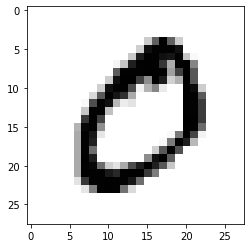

In [5]:
imshow(np.asarray(mnist[1][0]), cmap='gray_r') 

In [48]:
np.asarray(mnist[1][0]).shape

(28, 28)

In [6]:
with open('delta.png.base64', 'r') as f:
    data = f.read()

In [49]:
import tempfile

def base64_to_mnist(raw_data):
    trimmed = raw_data.split(',', 1)[-1]
    asbytes = base64.b64decode(trimmed)
    
    with tempfile.NamedTemporaryFile() as img_buffer:
        img_buffer.write(asbytes)
        as_pil = Image.open(img_buffer)
        as_pil.load()
        
    as_pil = as_pil.resize((28, 28)) # magic pytorch mnist-model friendly format
    as_pil = as_pil.convert('L')
    return as_pil

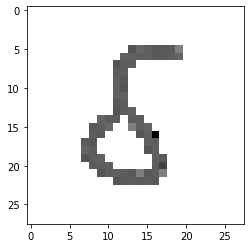

In [50]:
as_pil = base64_to_mnist(data)
imshow(as_pil, cmap='gray_r')

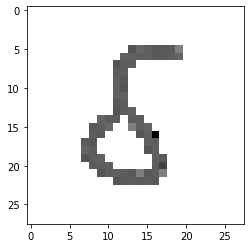

In [55]:
# torchvision.transforms.CenterCrop
import torchvision.transforms as transforms

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

transform_idem = transforms.Compose([
        transforms.ToTensor(),
        transforms.ToPILImage()
        ])

x = transform(as_pil)

debug_x = transform_idem(as_pil)
imshow(debug_x, cmap='gray_r') # adding in normalization changes this output ofc




In [46]:
y = transform(mnist[1][0])
y.shape, x.shape

(torch.Size([1, 28, 28]), torch.Size([1, 128, 128]))

In [52]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [53]:
model = Net() # Loads a pre-trained neural net model which matches user-defined Net class
state_dict = torch.load('mnist_cnn.pt')

model.load_state_dict(state_dict)
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [61]:
# run a prediction?
x_aslist = y[None, :, :, :]

model_input = base64_to_mnist(data)
pred_vec = model(x_aslist)

In [62]:
pred_vec.argmax()

tensor(0)